**Dependency**

In [ ]:
import numpy as np
import cv2
import os
from pathlib import Path
import pandas as pd
from skimage.feature import hog
from skimage import exposure


HOG Feature Extractor

**Overview of DATA** : 986 humman images and 986 non-human images and both are split in 830+ train and 138 test 

In [20]:
def get_hog_features(image_path):
    """Extract HOG features from an image."""
    image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Could not read image: {image_path}")

    image = cv2.resize(image, (128, 128))
    
    features, _ = hog(image,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      block_norm='L2-Hys',
                      visualize=True,
                      feature_vector=True)
    return features

            # base directory
base_dir = "/home/teaching/Documents/assignment/assignment_1/human-non-human"
categories = ['human', 'non-human']
splits = ['train', 'test']

for split in splits:
    features_list = []
    labels = []
    
    for category in categories:
        folder = Path(os.path.join(base_dir, category, split))
        label = category.lower().replace('-', ' ')  
        
        for img_path in folder.glob('*.jpg'):
            try:
                features = get_hog_features(img_path)
                features_list.append(features)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    
    if not features_list:
        print(f"No images found for {split}")
        continue

    feature_columns = [f'hog_{i}' for i in range(len(features_list[0]))]
    df = pd.DataFrame(features_list, columns=feature_columns)
    df['label'] = labels
    
    output_path = f'human-non-human_{split}.csv'
    df.to_csv(output_path, index=False)
    print(f"Saved {output_path} with {len(df)} samples.")


Saved human-non-human_train.csv with 1676 samples.
Saved human-non-human_test.csv with 296 samples.


**KNN and SVM**

K=1, Metric=euclidean, Test Accuracy=0.8514
K=1, Metric=manhattan, Test Accuracy=0.9459
K=1, Metric=chebyshev, Test Accuracy=0.6115
K=1, Metric=minkowski, Test Accuracy=0.8514
K=3, Metric=euclidean, Test Accuracy=0.8243
K=3, Metric=manhattan, Test Accuracy=0.9459
K=3, Metric=chebyshev, Test Accuracy=0.5642
K=3, Metric=minkowski, Test Accuracy=0.8243
K=5, Metric=euclidean, Test Accuracy=0.8041
K=5, Metric=manhattan, Test Accuracy=0.9358
K=5, Metric=chebyshev, Test Accuracy=0.5507
K=5, Metric=minkowski, Test Accuracy=0.8041
K=7, Metric=euclidean, Test Accuracy=0.7838
K=7, Metric=manhattan, Test Accuracy=0.9358
K=7, Metric=chebyshev, Test Accuracy=0.5372
K=7, Metric=minkowski, Test Accuracy=0.7838
K=9, Metric=euclidean, Test Accuracy=0.7939
K=9, Metric=manhattan, Test Accuracy=0.9324
K=9, Metric=chebyshev, Test Accuracy=0.5405
K=9, Metric=minkowski, Test Accuracy=0.7939


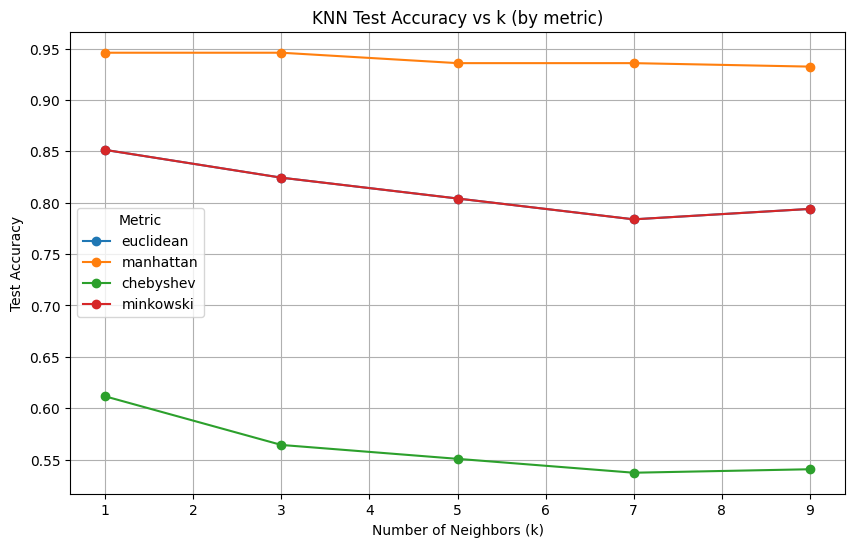

K=linear, Metric=0.1, Test Accuracy=0.9662
K=linear, Metric=1, Test Accuracy=0.9662
K=linear, Metric=10, Test Accuracy=0.9662
K=rbf, Metric=0.1, Test Accuracy=0.9020
K=rbf, Metric=1, Test Accuracy=0.9595
K=rbf, Metric=10, Test Accuracy=0.9628
K=poly, Metric=0.1, Test Accuracy=0.6757
K=poly, Metric=1, Test Accuracy=0.8682
K=poly, Metric=10, Test Accuracy=0.8615


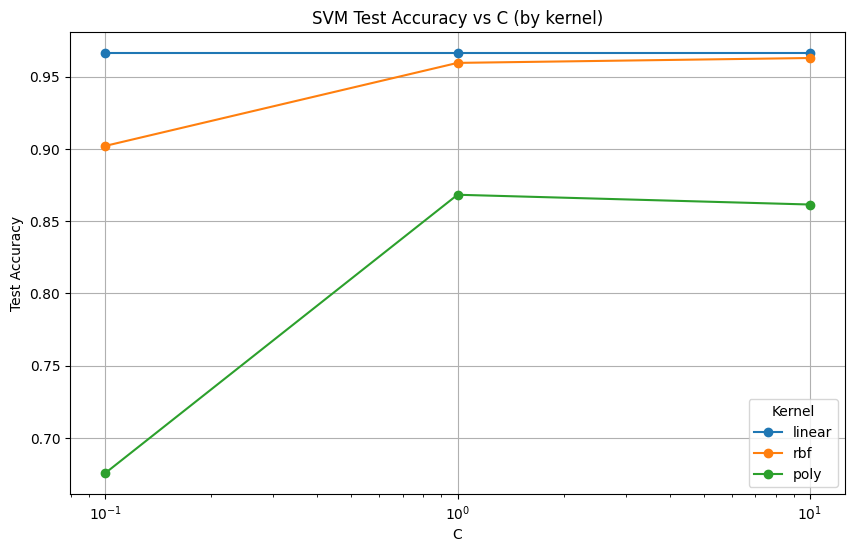

In [ ]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from itertools import product

def load_data(filename):
    df = pd.read_csv(filename)
    X = df.iloc[:, :-1].values 
    y = df.iloc[:, -1].values  
    return X, y

X_train, y_train = load_data('/home/teaching/Documents/assignment/assignment_1/hog_csv/human-non-human_train.csv')
X_test, y_test = load_data('/home/teaching/Documents/assignment/assignment_1/hog_csv/human-non-human_test.csv')

        # Normalizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

k_values = [1, 3, 5, 7, 9]
metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
knn_test_scores = []

for k, metric in product(k_values, metrics):
    knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
    knn.fit(X_train, y_train)
    y_test_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_test_pred)
    knn_test_scores.append((k, metric, acc))


for k, metric, acc in knn_test_scores:
    print(f"K={k}, Metric={metric}, Test Accuracy={acc:.4f}")


        # Plotting KNN test accuracy
knn_df = pd.DataFrame(knn_test_scores, columns=['k', 'metric', 'test_acc'])

plt.figure(figsize=(10,6))
for metric in metrics:
    subset = knn_df[knn_df['metric'] == metric]
    plt.plot(subset['k'], subset['test_acc'], marker='o', label=metric)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Test Accuracy')
plt.title('KNN Test Accuracy vs k (by metric)')
plt.legend(title='Metric')
plt.grid(True)
plt.show()

kernels = ['linear', 'rbf', 'poly']
C_values = [0.1, 1, 10]
svm_test_scores = []

for kernel, C in product(kernels, C_values):
    svm = OneVsRestClassifier(SVC(kernel=kernel, C=C))
    svm.fit(X_train, y_train)
    y_test_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_test_pred)
    svm_test_scores.append((kernel, C, acc))

for k, metric, acc in svm_test_scores:
    print(f"K={k}, Metric={metric}, Test Accuracy={acc:.4f}")

    # Plotting SVM test accuracy
svm_df = pd.DataFrame(svm_test_scores, columns=['kernel', 'C', 'test_acc'])

plt.figure(figsize=(10,6))
for kernel in kernels:
    subset = svm_df[svm_df['kernel'] == kernel]
    plt.plot(subset['C'], subset['test_acc'], marker='o', label=kernel)
plt.xlabel('C')
plt.ylabel('Test Accuracy')
plt.title('SVM Test Accuracy vs C (by kernel)')
plt.xscale('log')
plt.legend(title='Kernel')
plt.grid(True)
plt.show()


**Trainning SVM on Human vs Non Human DATA**

Loading training data...
Loading human images from /home/teaching/Documents/assignment/assignment_1/human-non-human/human/train
Loading non-human images from /home/teaching/Documents/assignment/assignment_1/human-non-human/non-human/train
Loaded 1676 training samples: 838 humans, 838 non-humans
Training SVM model...
Loading test data...
Loading human images from /home/teaching/Documents/assignment/assignment_1/human-non-human/human/test
Loading non-human images from /home/teaching/Documents/assignment/assignment_1/human-non-human/non-human/test
Loaded 296 test samples: 148 humans, 148 non-humans
Evaluating model...
Accuracy: 0.9628
Classification Report:
              precision    recall  f1-score   support

   Non-Human       0.97      0.96      0.96       148
       Human       0.96      0.97      0.96       148

    accuracy                           0.96       296
   macro avg       0.96      0.96      0.96       296
weighted avg       0.96      0.96      0.96       296



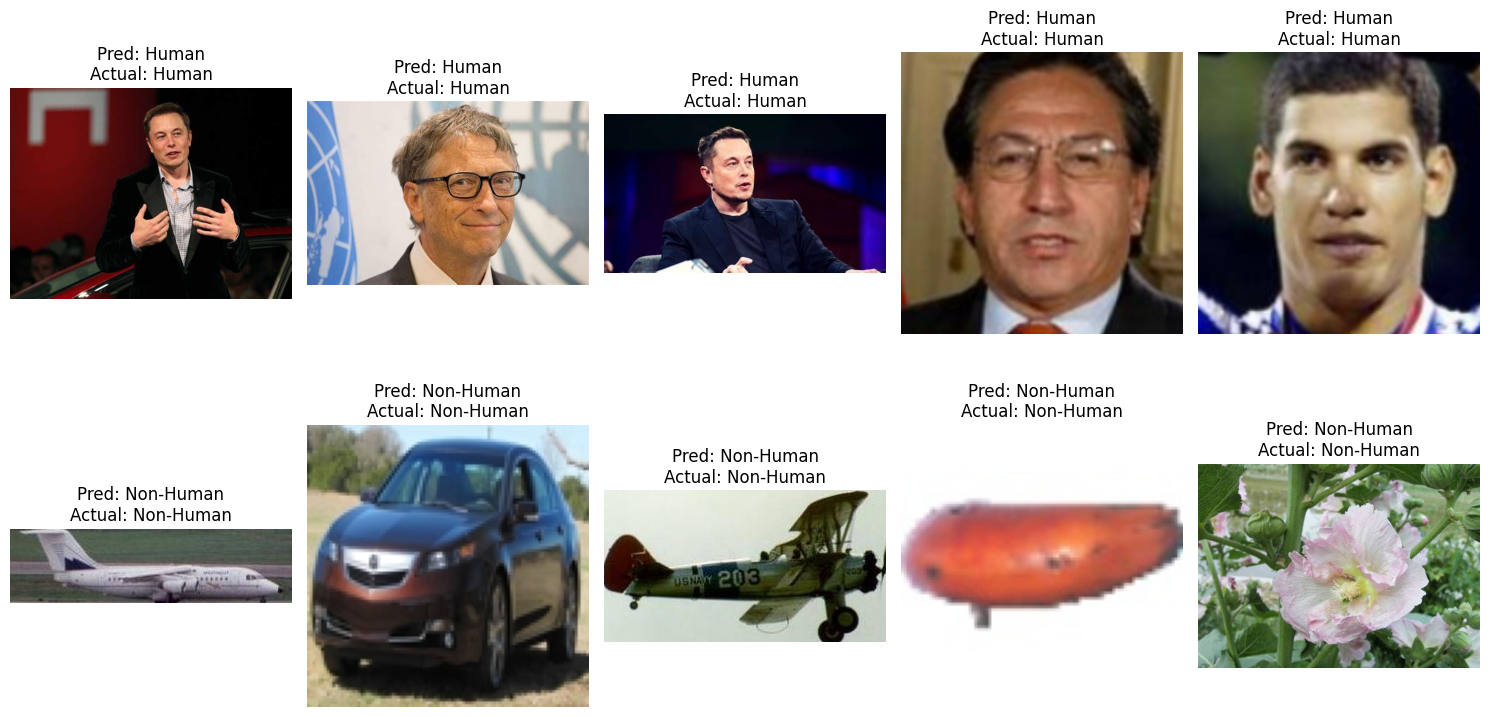

Model saved as 'human_nonhuman_svm_model.pkl'


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Define paths
train_human_dir = '/home/teaching/Documents/assignment/assignment_1/human-non-human/human/train'
train_nonhuman_dir = '/home/teaching/Documents/assignment/assignment_1/human-non-human/non-human/train'
test_human_dir = '/home/teaching/Documents/assignment/assignment_1/human-non-human/human/test'
test_nonhuman_dir = '/home/teaching/Documents/assignment/assignment_1/human-non-human/non-human/test'

def extract_hog_features(image_path, resize_dim=(128, 128)):
    """Extract HOG features from image"""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read image {image_path}")
        return np.zeros(3780)  
    
    img = cv2.resize(img, resize_dim)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
        ####HOG parameters
    win_size = (128, 128)
    block_size = (16, 16)
    block_stride = (8, 8)
    cell_size = (8, 8)
    nbins = 9
    
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    
    hog_features = hog.compute(gray)
    
    return hog_features.flatten()

def load_data(human_dir, nonhuman_dir):
    features = []
    labels = []
    
    print(f"Loading human images from {human_dir}")
    for img_file in os.listdir(human_dir):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(human_dir, img_file)
            features.append(extract_hog_features(img_path))
            labels.append(1)  # 1 for human
    
    print(f"Loading non-human images from {nonhuman_dir}")
    for img_file in os.listdir(nonhuman_dir):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(nonhuman_dir, img_file)
            features.append(extract_hog_features(img_path))
            labels.append(0)  # 0 for non-human
    
    return np.array(features), np.array(labels)

print("Loading training data...")
X_train, y_train = load_data(train_human_dir, train_nonhuman_dir)
print(f"Loaded {len(X_train)} training samples: {np.sum(y_train)} humans, {len(y_train) - np.sum(y_train)} non-humans")

print("Training SVM model...")
svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=1.0, probability=True))
])
svm_model.fit(X_train, y_train)

print("Loading test data...")
X_test, y_test = load_data(test_human_dir, test_nonhuman_dir)
print(f"Loaded {len(X_test)} test samples: {np.sum(y_test)} humans, {len(y_test) - np.sum(y_test)} non-humans")

print("Evaluating model...")
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Non-Human', 'Human'])

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

def plot_predictions(X_test, y_test, y_pred, test_human_dir, test_nonhuman_dir, num_samples=5):
    plt.figure(figsize=(15, 8))
    
    human_files = [f for f in os.listdir(test_human_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    nonhuman_files = [f for f in os.listdir(test_nonhuman_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for i in range(min(num_samples, len(human_files))):
        img_path = os.path.join(test_human_dir, human_files[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        idx = i 
        pred = "Human" if y_pred[idx] == 1 else "Non-Human"
        actual = "Human"
        
        plt.subplot(2, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {pred}\nActual: {actual}")
        plt.axis('off')
    
    for i in range(min(num_samples, len(nonhuman_files))):
        img_path = os.path.join(test_nonhuman_dir, nonhuman_files[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        idx = len(human_files) + i  
        pred = "Human" if y_pred[idx] == 1 else "Non-Human"
        actual = "Non-Human"
        
        plt.subplot(2, num_samples, num_samples+i+1)
        plt.imshow(img)
        plt.title(f"Pred: {pred}\nActual: {actual}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

try:
    plot_predictions(X_test, y_test, y_pred, test_human_dir, test_nonhuman_dir)
except Exception as e:
    print(f"Could not plot predictions: {e}")

#        Saving the trained model
import pickle
with open('human_nonhuman_svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)
print("Model saved as 'human_nonhuman_svm_model.pkl'")

Processing /home/teaching/Documents/assignment/assignment_1/multi-person/Pasted image.png...
  Found 4 humans, saved to /home/teaching/Documents/assignment/assignment_1/output-multi-person/detected_Pasted image.png


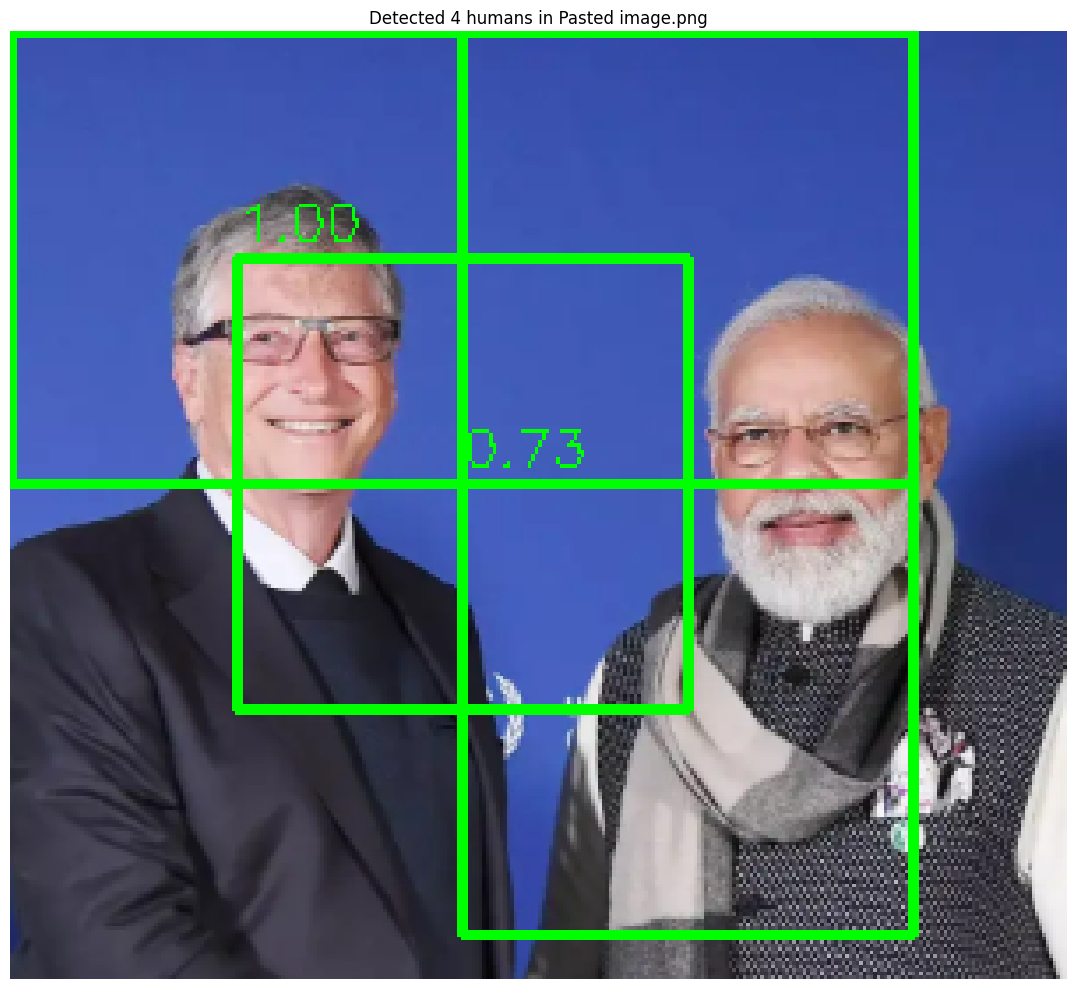

In [ ]:
import pickle
from sklearn.preprocessing import StandardScaler

model_file = 'human_nonhuman_svm_model.pkl'
with open(model_file, 'rb') as f:
    svm_model = pickle.load(f)

def extract_hog_features(img, resize_dim=(128, 128)):
    img_resized = cv2.resize(img, resize_dim)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
    # HOG parameters
    win_size = (128, 128)
    block_size = (16, 16)
    block_stride = (8, 8)
    cell_size = (8, 8)
    nbins = 9
    
    # Initialize HOG descriptor
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    
    # Compute HOG features
    hog_features = hog.compute(gray)
    
    return hog_features.flatten()

def sliding_window_detection(image_path, window_size=(128, 128), stride=32, confidence_threshold=0.6):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image {image_path}")
        return None
    
    result_img = img.copy()
    height, width = img.shape[:2]

    detections = []
    
    for y in range(0, height - window_size[1], stride):
        for x in range(0, width - window_size[0], stride):
            window = img[y:y + window_size[1], x:x + window_size[0]]
            
            features = extract_hog_features(window)
            features = features.reshape(1, -1) 
            
            prob = svm_model.predict_proba(features)[0]
            human_prob = prob[1]  
            if human_prob > confidence_threshold:
                detections.append((x, y, window_size[0], window_size[1], human_prob))
    
    detections = non_max_suppression(detections, 0.3)
    
    for (x, y, w, h, prob) in detections:
        color = (0, 255, 0)
        thickness = 2
        cv2.rectangle(result_img, (x, y), (x + w, y + h), color, thickness)
        
        text = f"{prob:.2f}"
        cv2.putText(result_img, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    return result_img, detections

def non_max_suppression(boxes, overlap_threshold):
    if len(boxes) == 0:
        return []
    
    boxes_array = np.array(boxes)
    
    x1 = boxes_array[:, 0]
    y1 = boxes_array[:, 1]
    x2 = boxes_array[:, 0] + boxes_array[:, 2]
    y2 = boxes_array[:, 1] + boxes_array[:, 3]
    scores = boxes_array[:, 4]
    
    idxs = np.argsort(scores)[::-1]
    
    pick = []
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[0]
        pick.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[1:]])
        yy1 = np.maximum(y1[i], y1[idxs[1:]])
        xx2 = np.minimum(x2[i], x2[idxs[1:]])
        yy2 = np.minimum(y2[i], y2[idxs[1:]])
        
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        overlap = (w * h) / ((x2[i] - x1[i] + 1) * (y2[i] - y1[i] + 1) + 
                             (x2[idxs[1:]] - x1[idxs[1:]] + 1) * (y2[idxs[1:]] - y1[idxs[1:]] + 1) - w * h)
        
        idxs = np.delete(idxs, np.concatenate(([0], np.where(overlap > overlap_threshold)[0] + 1)))
    
    return [boxes[i] for i in pick]

def process_test_images(test_dir, output_dir, num_images=5):
    os.makedirs(output_dir, exist_ok=True)
    
    image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    processed_images = 0
    results = []
    
    for img_file in image_files:
        if processed_images >= num_images:
            break
            
        img_path = os.path.join(test_dir, img_file)
        print(f"Processing {img_path}...")
        
        try:
            result_img, detections = sliding_window_detection(
                img_path, 
                window_size=(128, 128), 
                stride=64,
                confidence_threshold=0.7
            )
            
            if result_img is not None:
                output_path = os.path.join(output_dir, f"detected_{img_file}")
                cv2.imwrite(output_path, result_img)
                
                results.append({
                    'image': result_img,
                    'original': img_path,
                    'detections': len(detections)
                })
                
                processed_images += 1
                print(f"  Found {len(detections)} humans, saved to {output_path}")
            
        except Exception as e:
            print(f"  Error processing {img_path}: {e}")
    
    return results

test_dir = '/home/teaching/Documents/assignment/assignment_1/multi-person'  # Update this path to your test directory
output_dir = '/home/teaching/Documents/assignment/assignment_1/output-multi-person'

try:
    results = process_test_images(test_dir, output_dir)
    
    plt.figure(figsize=(15, 10))
    for i, result in enumerate(results):
        plt.subplot(len(results), 1, i+1)
        plt.imshow(cv2.cvtColor(result['image'], cv2.COLOR_BGR2RGB))
        plt.title(f"Detected {result['detections']} humans in {os.path.basename(result['original'])}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error during processing: {e}")
    print("If the 'test/multi_person' directory doesn't exist, create it and add test images,")
    print("or modify the 'test_dir' variable to point to your directory with multi-person images.")

def detect_humans_in_image(image_path):
    """Detect humans in a single image and display the result"""
    try:
        result_img, detections = sliding_window_detection(
            image_path, 
            window_size=(128, 128), 
            stride=32,
            confidence_threshold=0.7
        )
        
        if result_img is not None:
            plt.figure(figsize=(12, 6))
            
            #####Original image
            plt.subplot(1, 2, 1)
            orig_img = cv2.imread(image_path)
            plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
            plt.title("Original Image")
            plt.axis('off')
            
            ####### Result image with detections
            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Detected {len(detections)} Humans")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print(f"Detected {len(detections)} humans in the image")
        else:
            print("Failed to process the image")
    
    except Exception as e:
        print(f"Error processing image: {e}")


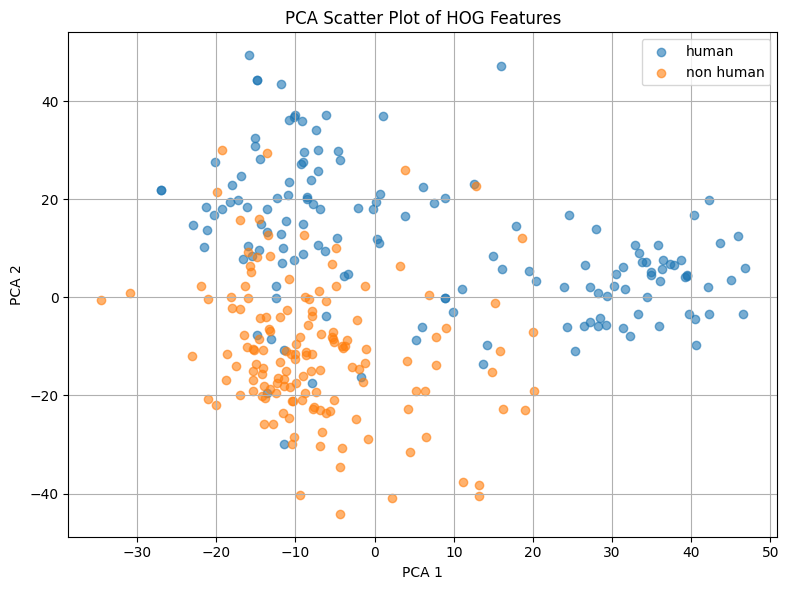

/home/teaching/miniconda3/envs/assign1/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


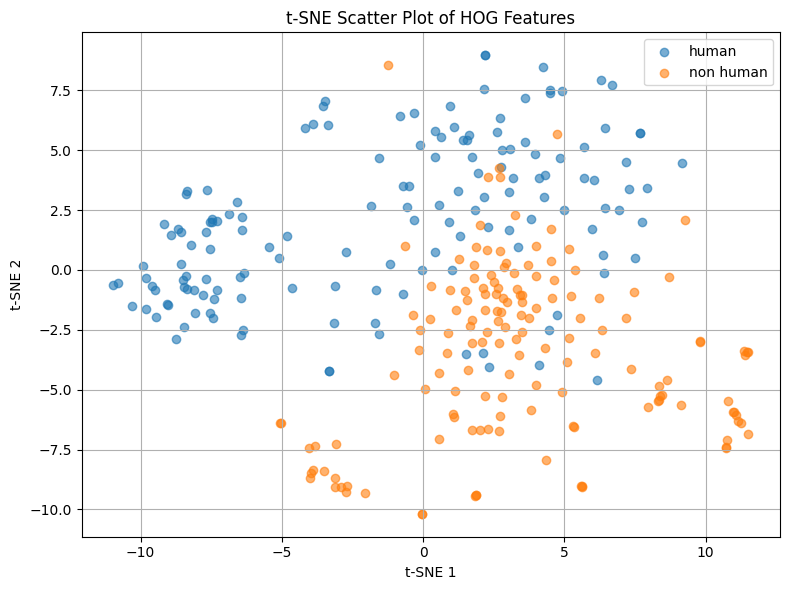

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def load_data(filename):
    df = pd.read_csv(filename)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return X, y

X_train, y_train = load_data('/home/teaching/Documents/assignment/assignment_1/hog_csv/human-non-human_train.csv')
X_test, y_test = load_data('/home/teaching/Documents/assignment/assignment_1/hog_csv/human-non-human_test.csv')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

         ##PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8, 6))
for label in np.unique(y_train):
    idx = y_train == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label, alpha=0.6)
plt.title('PCA Scatter Plot of HOG Features')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

        ##t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_train_scaled)

plt.figure(figsize=(8, 6))
for label in np.unique(y_train):
    idx = y_train == label
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=label, alpha=0.6)
plt.title('t-SNE Scatter Plot of HOG Features')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()